# **4. Classification**
#### Juan Julián Cea Morán

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Electronic-Arts-Logo.svg/1200px-Electronic-Arts-Logo.svg.png" width=100px>

---
Once we have normalized and tokenied the data, it is time to build some classification models. In this case, the required task is a supervised classification problem, since we have pre-labeled data to work with. To addres this problem, we will be using classifiers like Multinomial Naive Bayes or Suppor Vector Machine.

But, before feeding the data into the models, let's prepare the datasets.

---
## Prepare datasets
We have to create train and test dataset, so we have to split our dataset. But before do that, there are some operations that we need to perform.

First of all, we have to import the data and then, encode the categories into diferent numeric labels, conforming the targets.

In [77]:
import pickle
import pandas as pd

preproc_df = pickle.load(open("../data/preproc_df.pkl", 'rb'))

In [78]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
preproc_df['Target'] = le.fit_transform([cat for cat in preproc_df['Category']])

In [79]:
labels = list(set(preproc_df['Category'].tolist()))

In [80]:
preproc_df.head()

,Preprocessed,Lang,Category,Target
0,"[read, book, town, everyone, uses, order, phar...",en,APR,0
1,"[recipes, appreciated, family, small, large, r...",en,APR,0
2,"[say, ease, author, even, made, effort, meet, ...",en,APR,0
3,"[milady, found, good, vein, anita, blake, base...",en,APR,0
4,"[somewhere, greece, gentlemen, decided, visit,...",en,APR,0


We need also to shuffle all samples.

In [81]:
preproc_df = preproc_df.sample(frac=1).reset_index(drop=True)

In [82]:
preproc_df.head()

,Preprocessed,Lang,Category,Target
0,"[region, rabat-sale-, zemmour-zaer, province, ...",fr,Wikipedia,3
1,"[runs, narrow, channel, deep, xarayes, sail, b...",en,PAN11,2
2,"[admiration, sanson, disappeared, album, since...",en,APR,0
3,"[time, able, play, real, place, two, thousand,...",en,PAN11,2
4,"[warning, dvd, contains, version, play, design...",en,APR,0


Now, it's time to split the dataset. To do that, we are gonna take 90% for train and 10% for test.

In [83]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(preproc_df, test_size=0.1)

In [84]:
import numpy as np

Y_train = np.asarray(train_df['Target'].tolist())
print(Y_train[0:15])

Y_test = np.asarray(test_df['Target'].tolist())
print(Y_test[0:15])

[3 3 2 0 0 3 0 3 0 0 3 3 2 0 3]
[2 3 3 3 3 2 3 0 3 3 3 0 3 2 3]


In [85]:
X_train = train_df['Preprocessed'].tolist()
print(type(X_train[0]))

X_test = test_df['Preprocessed'].tolist()
print(type(X_test[0]))

<class 'list'>
<class 'list'>


---

## Vectorize texts
The next step is to vectorize text. Our ML models are not able to work with strings, so we need to convert those strings into numbers. To do that, there are different approaches.

For the pourpose of this test, we are going to use some scikit-learn library.

In [86]:
%%time 
from sklearn.feature_extraction.text import TfidfVectorizer 

tfidf_vect = TfidfVectorizer(use_idf=True, min_df=12)
X_train = tfidf_vect.fit_transform([' '.join(text) for text in X_train])
X_test = tfidf_vect.transform([' '.join(text) for text in X_test])

print(type(X_train))

<class 'scipy.sparse.csr.csr_matrix'>
Wall time: 12.6 s


---
## Implementing the model
Once we have our data ready, it's time to test some models and get results. We are going to test models using scikit-learn library, which I said before is widely used in this domain.

#### **1. Multinomial Naive Bayes**
This classifier is suitable for text classification, since it is intended to be used with discrete features like word counts.

First, we have to train the model using the training data.

In [87]:
%%time
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train, Y_train)

Wall time: 59.8 ms


MultinomialNB()

Now that the model is trained, it is ready to perform some predictions. We are using the score method to get the accuracy of the model.

In [88]:
Y_pred = clf.predict(X_test)

In [89]:
from sklearn import metrics

print('Accuracy MultinomialNB: ' + str(100 * metrics.accuracy_score(Y_test, Y_pred)) + '%')

Accuracy MultinomialNB: 95.35186794092094%


Another useful metric for supervised classification problem is the **confusion matrix**. This metric give us an indication of how the model is performing in terms of true and false positives. Each row represents instances of actual classes and each column represent instances predicted classes, so it is possible to detect for wich categories the model is misclassifying the samples.

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, normalize=False, figsize=(10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [91]:
from sklearn import metrics

# Inverse transform the label encoding
Y_test_cat = le.inverse_transform(Y_test)
Y_pred_cat = le.inverse_transform(Y_pred)

conf = metrics.confusion_matrix(Y_test, Y_pred)

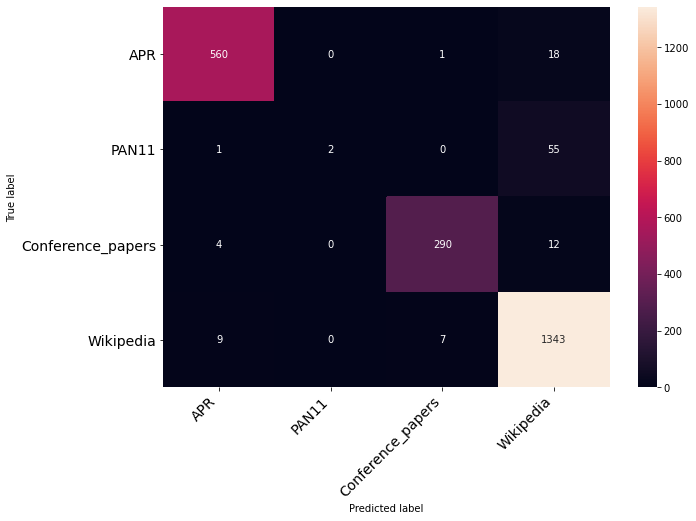

In [92]:
print_confusion_matrix(conf, labels);

#### **Conclusions of MultinomialNB**

As we can see, the model performs with and accuracy of 95'35%, wich is a very good result as starting point.

Looking at Confusion Matrix, we can see that the worst classified examples are those belonging to PAN11 class with only 2 correct results and 56 wrong classified examples. APR, WIkipedia and Conference_papers examples are quite good classified, but with improvement margin.

With regard to training time, this model stands out for being very efficient, giving a computation time of 76.8 ms.

Let's try other model to see if it outperforms the Multinomial Naive Bayes.

---

#### **2. Linear Support Vector Machine**
This also a good algorithm for supervised learning tasks. I'm going to test scikit-learn implementation.

First, we have to train the model using the training data.

In [93]:
%%time
from sklearn.svm import LinearSVC

clf = LinearSVC()
clf.fit(X_train, Y_train)

Wall time: 986 ms


LinearSVC()

Now that the model is trained, it is ready to perform some predictions. We are using the score method to get the accuracy of the model.

In [94]:
%%time
Y_pred = clf.predict(X_test)

Wall time: 8.97 ms


In [95]:
from sklearn import metrics

print('Accuracy Support Vector Machine: ' + str(100 * metrics.accuracy_score(Y_test, Y_pred)) + '%')

Accuracy Support Vector Machine: 98.74022589052997%


Again, let's use **confusion matrix**.

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, normalize=False, figsize=(10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [97]:
from sklearn import metrics

# Inverse transform the label encoding
Y_test_cat = le.inverse_transform(Y_test)
Y_pred_cat = le.inverse_transform(Y_pred)

conf = metrics.confusion_matrix(Y_test, Y_pred)

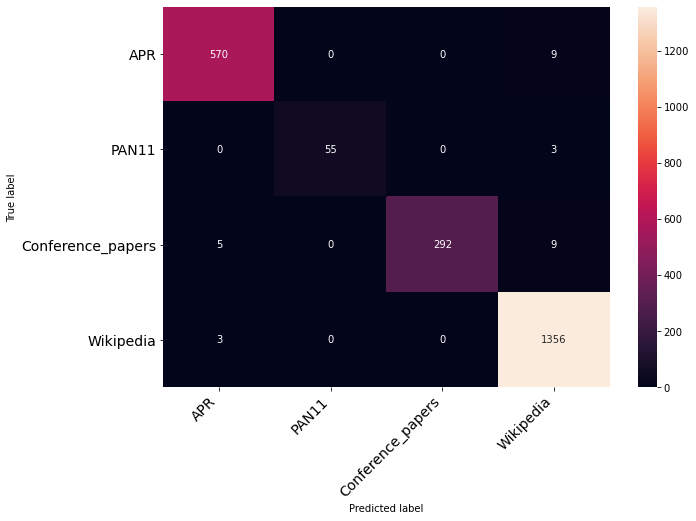

In [98]:
print_confusion_matrix(conf, labels);

#### **Conclusions of LinearSVC**

In this case, we can see how the model give us a better accuracy value: 98,7%.

The confusion matrix also reveal some interesting results. As we can see, now the PAN11 documents are better classified (55 correct results) while whith MultinomialNB almost every sample was misclassified. The resulst of Wikipedia are lightly better, since the last model was capable of classifying correctly 1343 samples and this model 1356. The results of Conference_papers are also slightly better.

Just like in the previous model, the training time is very good: 987ms.

---

## Final design
As we have seen, both models are capable of performing adequately for the required tearea. Based on the extracted metrics, we will use LinearSVC as the final model. A processing pipeline will be implemented for this purpose.

**Important:** Please, keep in mind that this final group of cells need to be independently executed, since there will be variables computed in the previous steps.

**Updated:** Added required cells at the beginning of this section so it's no necessary to keep track of variables. Those cells correspond to the first cells of this notebook but without coments.

In [99]:
import pickle
import pandas as pd

preproc_df = pickle.load(open("../data/preproc_df.pkl", 'rb'))

In [100]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
preproc_df['Target'] = le.fit_transform([cat for cat in preproc_df['Category']])

In [101]:
labels = list(set(preproc_df['Category'].tolist()))

In [102]:
preproc_df = preproc_df.sample(frac=1).reset_index(drop=True)

In [103]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(preproc_df, test_size=0.1)

In [104]:
import numpy as np

Y_train = np.asarray(train_df['Target'].tolist())
print(Y_train[0:15])

Y_test = np.asarray(test_df['Target'].tolist())
print(Y_test[0:15])

[3 3 3 3 3 3 3 2 3 3 3 3 3 3 3]
[3 3 3 3 2 3 3 3 3 3 2 3 0 3 3]


In [105]:
X_train = train_df['Preprocessed'].tolist()
print(type(X_train[0]))

X_test = test_df['Preprocessed'].tolist()
print(type(X_test[0]))

<class 'list'>
<class 'list'>


Implementing the pipeline

In [106]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.svm import LinearSVC

pipe = Pipeline([
    ('vect', TfidfVectorizer(min_df=12, tokenizer=None)),
    ('clf', LinearSVC())
])

In [107]:
pipe.fit([' '.join(text) for text in X_train], Y_train)

Pipeline(steps=[('vect', TfidfVectorizer(min_df=12)), ('clf', LinearSVC())])

In [108]:
print('Final accuracy score: ' + str(pipe.score([' '.join(text) for text in X_test], Y_test)*100) + '%')

Final accuracy score: 98.56646394439618%


 Now, let's save and dump the model

In [109]:
from joblib import dump

dump(pipe, '../data/classification_model.joblib')

['../data/classification_model.joblib']

---
